# Metals

# Библиотеки

In [21]:
import hydra
from hydra import initialize, compose
from omegaconf import OmegaConf
import random
import torch
from IPython.display import clear_output
import subprocess
from pathlib import Path
from PIL import Image
import numpy as np
import torch
import pandas as pd
import torch
from hydra.utils import instantiate
from src.modules import DefaultModule
from src.datamodules import DefaultDataModule
from lightning.pytorch.loggers import WandbLogger
import torchvision.transforms.functional as F
import lightning as L
import wandb
import optuna
import lovely_tensors as lt
lt.monkey_patch()



from src.metrics import Accuracy
from src.transforms_and_augs import transform, augment

## Конфиг

In [2]:
with initialize(config_path='../configs', job_name='demo', version_base='1.3'):
    cfg = compose(config_name='config')

print('Hydra Config:\n')
print(OmegaConf.to_yaml(cfg))

Hydra Config:

project:
  name: Metals
  seed: 42
  device: cuda
  wandb_entity: sasha_kovylyaev-hse
target: Fe
dataset:
  _target_: src.datasets.default.DefaultDataset
  img_paths: null
  answers_file: null
  transform: null
  augment: null
  train: null
model:
  _target_: src.models.default.DefaultModel
  weights: null
  output_dim: 1
training:
  img_dir: data/prepared_data/images
  answer_file: data/prepared_data/answer.csv
  batch_size: 16
  n_epochs: 25
  train_size: 0.7
  val_size: 0.15
  test_size: 0.15
  precision: 32
optimizer:
  _target_: torch.optim.Adam
  params: null
  lr: 0.001
criterion:
  _target_: src.criterions.default.WeightedMSELoss
scheduler:
  _target_: null



# Настройки окружения

In [3]:
%load_ext autoreload
%autoreload 2

SEED = cfg.project.seed
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# device = torch.device(cfg.project.device if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device

device(type='mps')

In [4]:
try:
    print("Подготовка данных...")
    subprocess.run(['make', '-C', str(Path.cwd().parent), 'prepare_data', f'target_column=Fe'], check=True, text=True, capture_output=True)
    print("Подготовка данных завершена")
except subprocess.CalledProcessError as e:
    print("Ошибка при подготовке данных:")
    print(e.stderr)
    raise e

Подготовка данных...
Подготовка данных завершена


## Ауги и трансформации

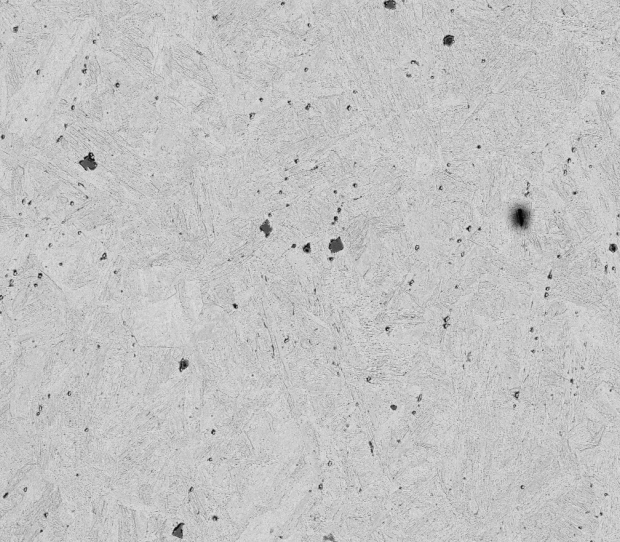

In [23]:
image = Image.open('/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/CPJ-1_1.png')
im = np.asarray(image)
ten = augment(im)
t = F.to_pil_image(ten)
t

# Данные

## Посмотреть данные

In [6]:
answers = pd.read_csv('/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/answer.csv', index_col=0)
answers.head(4)

,Fe,weight
/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/CPJ-13_19.png,80.655,1.743056
/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/CPJ-13_24.png,80.655,1.743056
/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/CPJ-13_18.png,80.655,1.743056
/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/CPJ-13_20.png,80.655,1.743056


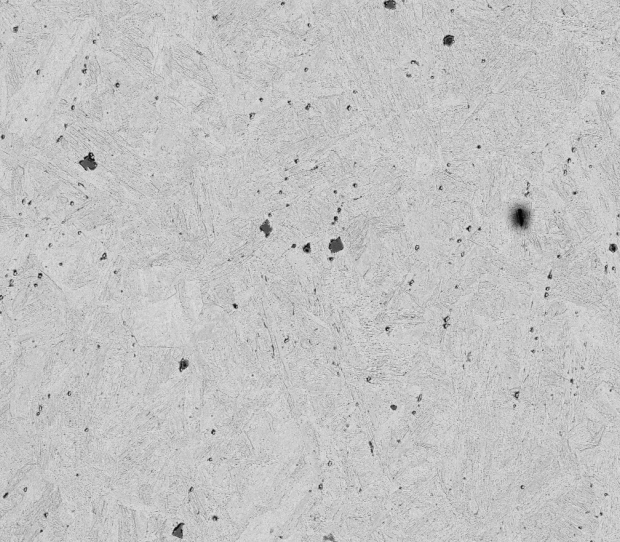

In [7]:
image = Image.open('/Users/aleksandr/Kursovay_METALs/Metals/data/prepared_data/images/CPJ-1_1.png')
image = image.convert('RGB')
image

# Метрики

In [8]:
# Accuracy
acc = Accuracy()

acc.update(torch.tensor([[1,0,0], [0,1,0], [0,0,1]]), torch.tensor([0,0,2]))
acc.compute()

0.6666666865348816

## Параметры предобучения

# Подбор гиперпараметров

In [ ]:
def objective(trial):
    # Гиперпараметры
    model = trial.suggest_categorical("model", ['resnet50', 'mobilenet_v3_small', 'efficientnet_v2_m'])
    optimizer = trial.suggest_categorical("optimizer", ['AdamW'])
    scheduler = trial.suggest_categorical("scheduler", ['cosinelr', 'cosinerestarts', 'steplr'])
    weights = trial.suggest_categorical("model_weights", ['DEFAULT'])
    lr = trial.suggest_float("lr", 1e-5, 3e-2, log=True)

    with initialize(config_path='../configs', job_name='demo', version_base='1.3'):
        trial_cfg = compose(config_name="config", overrides=[f'model={model}', f'optimizer={optimizer}', f'scheduler={scheduler}'])
    trial_cfg['model']['weights'] = weights
    trial_cfg['optimizer']['lr'] = weights

    data_module = DefaultDataModule(trial_cfg)
    module = DefaultModule(trial_cfg, data_module.scaler)

    wandb_config = OmegaConf.to_container(
        trial_cfg, resolve=True, throw_on_missing=True
    )
    wandb_logger = WandbLogger(project=trial_cfg.project.name, log_model=True)
    wandb_logger.log_hyperparams(wandb_config)


    trainer = L.Trainer(
        max_epochs=20,#trial_cfg.training.n_epochs,
        logger=wandb_logger,
        accelerator='mps',
        precision=trial_cfg.training.precision,
        log_every_n_steps=10,
    )
    trainer.fit(module, datamodule=data_module)

    val_loss = trainer.validate(ckpt_path='best', datamodule=data_module)[0]['val_loss']
    wandb_logger.finalize('success')
    wandb.finish()
    clear_output()
    return val_loss

# --- Запуск Optuna с прунингом ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=6)

# --- Лучший результат ---
print("Best trial:")
trial = study.best_trial
print(f"  Val loss: {trial.value:.4f}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-04-26 11:59:00,854] Trial 5 finished with value: 0.10304942727088928 and parameters: {'model': 'resnet50', 'optimizer': 'Adagrad', 'scheduler': 'default', 'model_weights': 'DEFAULT'}. Best is trial 5 with value: 0.10304942727088928.


Best trial:
  Val loss: 0.1030
  Params: 
    model: resnet50
    optimizer: Adagrad
    scheduler: default
    model_weights: DEFAULT


In [18]:
try:
    wandb_logger.finalize('success')
    wandb.finish()
except:
    pass

trials = study.get_trials()
for trial in trials:
    print(trial.params)

{'model': 'mobilenet_v3_small', 'optimizer': 'RMSprop', 'scheduler': 'cosinerestarts', 'model_weights': None}
{'model': 'resnet50', 'optimizer': 'default', 'scheduler': 'cosinelr', 'model_weights': None}
{'model': 'mobilenet_v3_small', 'optimizer': 'default', 'scheduler': 'cosinerestarts', 'model_weights': None}
{'model': 'resnet50', 'optimizer': 'AdamW', 'scheduler': 'steplr', 'model_weights': None}
{'model': 'mobilenet_v3_small', 'optimizer': 'RMSprop', 'scheduler': 'cosinerestarts', 'model_weights': 'DEFAULT'}
{'model': 'resnet50', 'optimizer': 'Adagrad', 'scheduler': 'default', 'model_weights': 'DEFAULT'}


In [12]:
# preds, trues = trainer.predict(ckpt_path='best', datamodule=data_module)[0]
# trues = list(trues.ravel())
# preds = list(preds.ravel())
# print("       True     Pred")
# for i in range(len(preds)):
#     print(trues[i], preds[i]) 

In [13]:
# data_module = DefaultDataModule(cfg)
# module = DefaultModule(cfg, data_module.scaler)

# wandb_config = OmegaConf.to_container(
#     cfg, resolve=True, throw_on_missing=True
# )
# wandb_logger = WandbLogger(project=cfg.project.name, log_model=True)
# wandb_logger.log_hyperparams(wandb_config)

# trainer = L.Trainer(
#     max_epochs=cfg.training.n_epochs,
#     logger=wandb_logger,
#     accelerator='mps',
#     precision=cfg.training.precision,
# )
# trainer.fit(module, datamodule=data_module)

In [14]:
# a = trainer.validate(ckpt_path='best', datamodule=data_module)
# # wandb_logger.finalize('success')
# # wandb.finish()
# a[0]['val_loss']

In [15]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights='DEFAULT')
# model.fc = nn.Linear(in_features=512, out_features=3, bias=True)
# model.load_state_dict(torch.load('/kaggle/working/states/best_model.pt'))

# model_scripted = torch.jit.script(model) # Export to TorchScript
# model_scripted.save('/kaggle/working/states/model_scripted.pt') 